# Module 2

The objective of this module is to tune some PID controllers for the flexible joint using different approaches.

1. First method of Ziegler-Nichols
2. Second method of Ziegler-Nichols
3. A cascade controller

The performance of the controllers in tracking and disturbance rejection will be compared.

---
__Manuals__
1. [Python Control System Library (MATLAB compatibility module)](https://python-control.readthedocs.io/en/0.9.2/matlab.html)
2. [Numpy](https://numpy.org/devdocs/index.html)
---

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this module.

Some instructions or examples will be provided for sections and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully!

This file will be used as your report. Any comments or answers should be added as `markdown` blocks inside the relevant subsection.

<div class="alert alert-block alert-warning">
<b>Warning:</b> Only the comments in <code>markdown</code> blocks and outputs of the cell will be considered for grading. Any comments inside the code blocks or variable which are not printed to output will be ignored. Use <code>View > Render Notebook with Voilà</code> menu to preview the rendered file which will be graded.
</div>

<div class="alert alert-block alert-warning">
<b>Note:</b> For comparing the controllers, plot the closed-loop responses and comment on the same.
</div>

---

### Imports
Import various dependencies <span style="color:red">(_Do not touch_)</span>

In [1]:
import control
from control.matlab import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math

control.config.use_numpy_matrix(False)
%matplotlib widget

# Set Numpy to only print upto 4th decimal
np.set_printoptions(formatter={'float': '{: 10.4f}'.format})

def print_system(text, sys):
    """Print LTI systems in a pretty manner.

    Parameters
    ----------
    text : str
        Name of the LTI system
    sys : LTI system
        System to pretty print
    """
    display(Math(f"\\text{{{text}}} = {sys._repr_latex_()[2:-2]}"))

### Load important variables/functions from previous modules
Use this to rewrite the important variables/functions from previous modules
(Try not to print any outputs here. Use this to just load the variables.)

In [2]:
Ka = 1.0
Rm = 2.2
Km = 0.00987
Kg = 60.0
Ks = 1.75
Jmot = 3.87e-7
Jmod = 3.922e-4
JBr = 0.004
b = 0.005

Jm=Jmod+pow(Kg,2)*Jmot
s = tf('s')
G = (Ks*Kg*Km*Ka)/((JBr*s*s+Ks)*(Rm*Jm*s*s+Rm*b*s+Km*Km*Kg*Kg*s)+Rm*Ks*JBr*s*s)
G = minreal(G)

# Print the TF
print_system("Plant (G)", G)

0 states have been removed from the model


<IPython.core.display.Math object>

### First method of Ziegler-Nichols
- Design a PID controller by the first method of Ziegler-Nichols.

__Note:__ This section needs the plant TF.

#### Step response
we display the step response and compute the L and R parameters

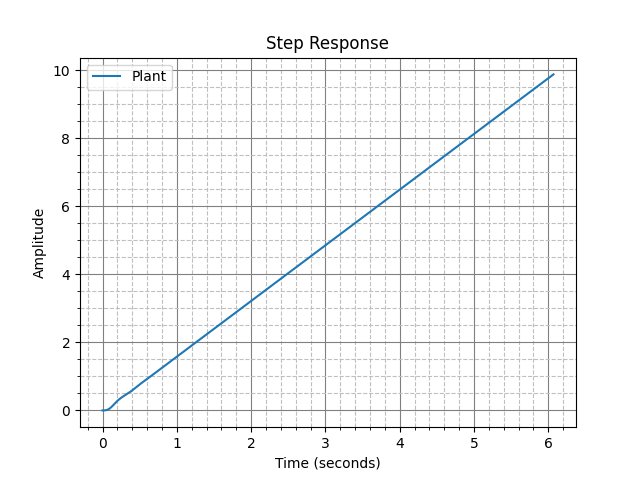

In [3]:
# Step Response of the plant
yout, tout = step(G)
plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)                                    # Plot data
plt.title('Step Response')                              # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Plant'])                                   # Display legend
plt.show()    

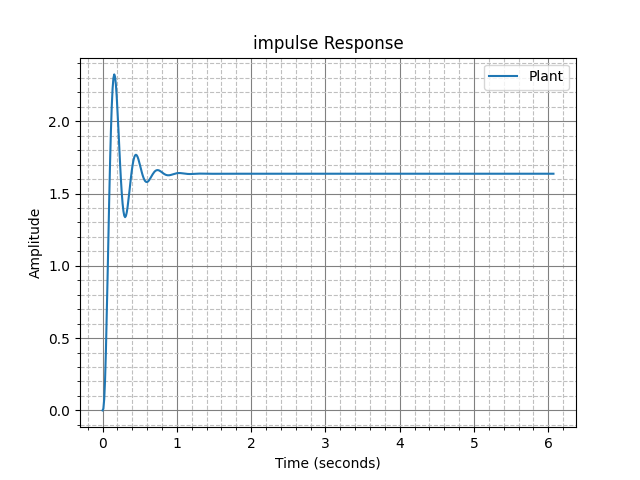

In [4]:
# impulse Response of the plant
yout, tout = impulse(G) #derivative of G to get the slope
plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)                                    # Plot data
plt.title('impulse Response')                              # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Plant'])                                   # Display legend
plt.show()

We can now use the step response to get the zero and the impulse response (that is the derivative) to get the slope


In [5]:
# TODO: Find parameters L & R
# Specify these variables:
#   * R -> Parameter R for controller design
#   * L -> Parameter L for controller design
# 
# Write upto 2th decimal
#   eg: L = 0.11
R=1.637
L=0.042



In [6]:
# TODO: Define PID Controller based on first method of Ziegler-Nichols
# Specify these variables:
#   * K -> Controller

Kp=1.2/(R*L)
Ti=2*L
Td=0.5*L

K=Kp*(1+1/(Ti*s)+Td*s)  #structure MIXED du PID (ZN donne que pour cette architecture)

<span style="color:red">__Q__:</span> Comment whether the synthesised PID controller usable in the real-world or not. If not, what can be done to solve the issue?  
<span style="color:blue">__A__:</span>
A low-pass filter (LPF) is often used in conjunction with a Proportional-Integral-Derivative (PID) controller to improve the system's stability and reduce overshoot because the system will tend to saturate the output if the there is an abrupt change which in practive can't be sustained by the system.

<div class="alert alert-block alert-info">

__Note:__ Use the real-world implementable version of PID controller for all future exercises!

</div>

In [7]:
# TODO: Define real-world implementable PID Controller based on first method of Ziegler-Nichols
# Specify these variables:
#   * K -> Controller
Kp=1.2/(R*L)
Ti=2*L
Td=0.5*L
print(Td)
tau=Td*0.1 # smaller by one order of magnitude

K=Kp*(1+1/(Ti*s)+(Td*s)/(tau*s+1))  #structure MIXED du PID (ZN donne que pour cette architecture)
print_system("Plant (K)", K)

0.021


<IPython.core.display.Math object>

0 states have been removed from the model
2 states have been removed from the model
6 states have been removed from the model
4 states have been removed from the model


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

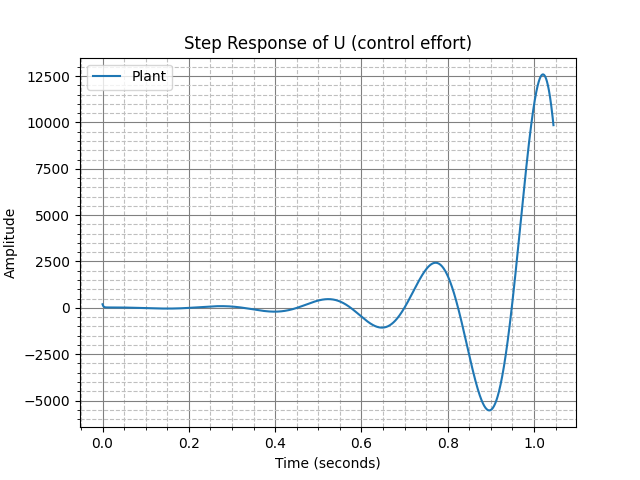

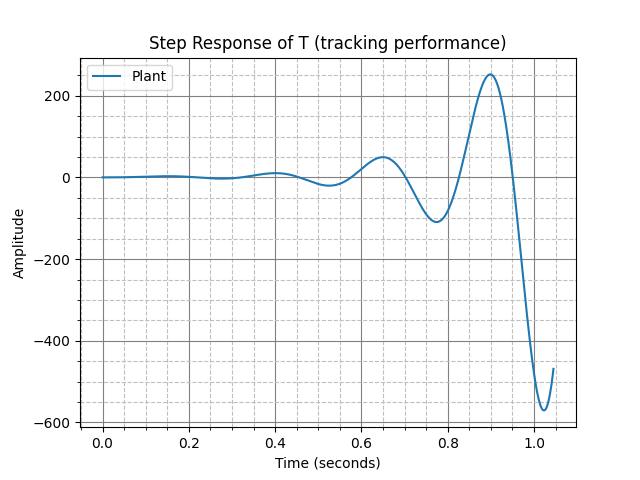

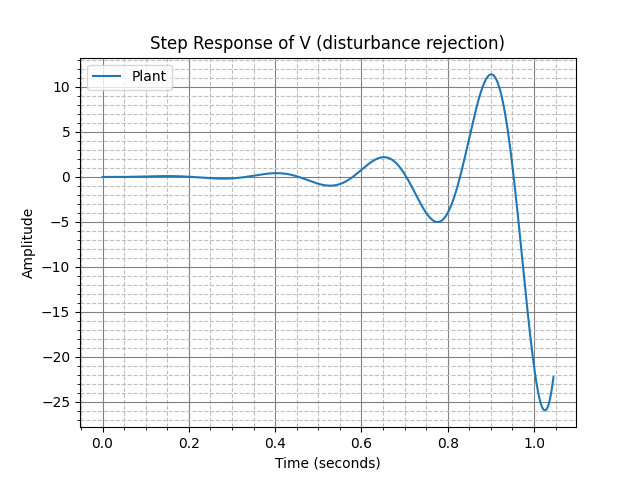

In [8]:
# TODO: Plot the step response of the closed-loop system
#   * from the reference signal to the output of the plant (tracking performance)
#   * after a step reference signal to the input of the plant (control effort)
#   * after a step disturbance at the input of the plant (disturbance rejection)
# 
#   Hint: You can use the closed loop TF defined in Module 1
# Step Response of the plant

#   * S -> TF between r and e ()
#   * U -> TF between r and u (control effort)
#   * T -> TF between r and y (tracking performance)
#   * V -> TF between w and y (disturbance rejection)
S = 1/(1+G*K)
S = minreal(S)
U = (K)/(1+G*K)
U = minreal(U)
T = (G*K)/(1+G*K)
T = minreal(T)
V = (G)/(1+G*K)
V = minreal(V)

# Print the TF
print_system("Plant (T)", T)
print_system("Plant (U)", U)
print_system("Plant (V)", V)


# Step Response of the plant
yout, tout = step(U)

plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)                                    # Plot data
plt.title('Step Response of U (control effort)')         # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Plant'])                                   # Display legend
plt.show()                                          # Show generated plot

# Step Response of the plant
yout, tout = step(T)

plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)                                    # Plot data
plt.title('Step Response of T (tracking performance)')         # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Plant'])                                   # Display legend
plt.show()     # Show generated plot

# Step Response of the plant
yout, tout = step(V)

plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)                                    # Plot data
plt.title('Step Response of V (disturbance rejection)') # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Plant'])                                   # Display legend
plt.show()                                          # Show generated plot

### Second method of Ziegler-Nichols
- Design a PID controller by the second method of Ziegler-Nichols.

__Note:__ This section needs the plant TF and its ultimate gain.

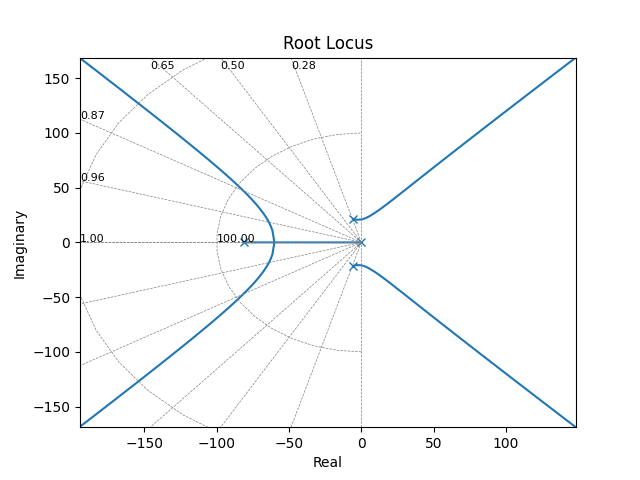

In [9]:
# TODO: Find the ultimate period of the plant
# Specify these variables:
#   * Pu -> Ultimate Period in seconds

# Root locus
#   Click on the plot to find the gain
plt.figure()
r = rlocus(G, plot=True)
plt.show()


to compute the ultimate period of the plant we use the root locus and find the y value where it cross the zero line

then we divide by 2 pi to get the frequency and we invert to get the periode

$$P_u=\frac{2*pi}{(y(0))}=\frac{2*pi}{(20.92)}=0.3003 [s]$$
$$K_u=6.498$$

In [10]:
# TODO: Define PID Controller based on second method of Ziegler-Nichols
# Specify these variables:
#   * K -> Controller
Ku=6.498
Pu=0.3003

Kp = 0.6*Ku
Ti = 0.5*Pu
Td = 0.125*Pu

K=Kp*(1+1/(Ti*s)+(Td*s)/(tau*s+1))  #structure MIXED du PID (ZN donne que pour cette architecture)
print_system("Plant (K)", K)


<IPython.core.display.Math object>

0 states have been removed from the model
2 states have been removed from the model
6 states have been removed from the model
4 states have been removed from the model


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

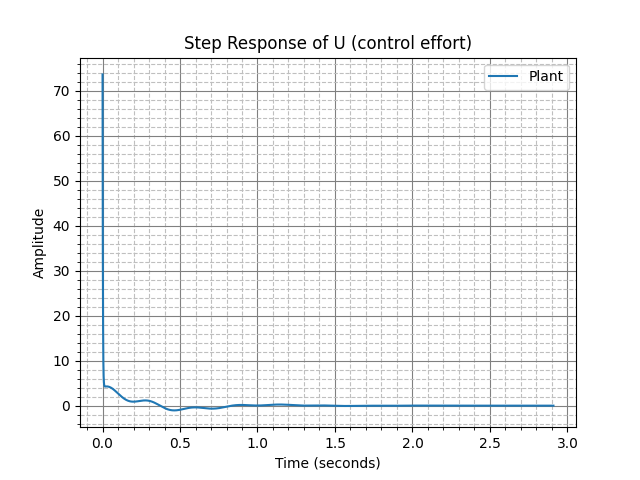

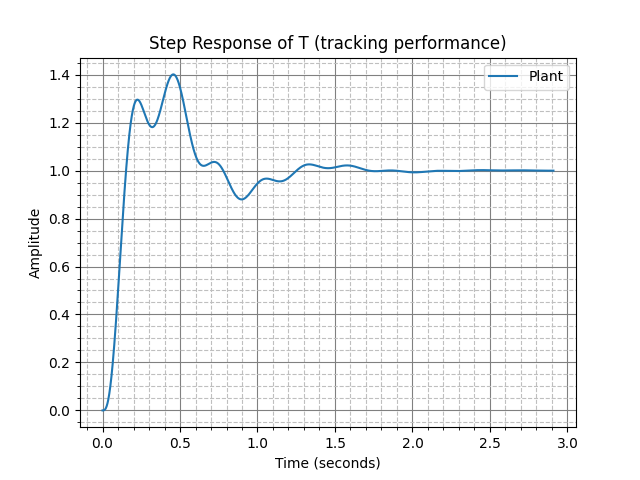

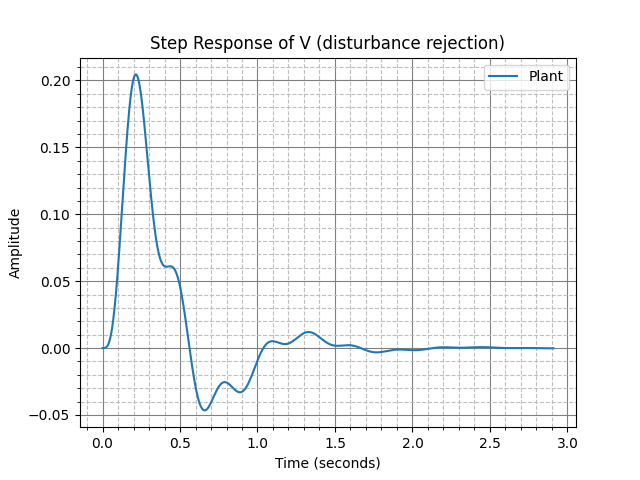

In [11]:
# TODO: Plot the step response of the closed-loop system
#   * from the reference signal to the output of the plant (tracking performance)
#   * after a step reference signal to the input of the plant (control effort)
#   * after a step disturbance at the input of the plant (disturbance rejection)

# TODO: Plot the step response of the closed-loop system
#   * from the reference signal to the output of the plant (tracking performance)
#   * after a step reference signal to the input of the plant (control effort)
#   * after a step disturbance at the input of the plant (disturbance rejection)
# 
#   Hint: You can use the closed loop TF defined in Module 1
# Step Response of the plant

#   * S -> TF between r and e ()
#   * U -> TF between r and u (control effort)
#   * T -> TF between r and y (tracking performance)
#   * V -> TF between w and y (disturbance rejection)
S = 1/(1+G*K)
S = minreal(S)
U = (K)/(1+G*K)
U = minreal(U)
T = (G*K)/(1+G*K)
T = minreal(T)
V = (G)/(1+G*K)
V = minreal(V)

# Print the TF
print_system("Plant (T)", T)
print_system("Plant (U)", U)
print_system("Plant (V)", V)


# Step Response of the plant
yout, tout = step(U)

plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)                                    # Plot data
plt.title('Step Response of U (control effort)')         # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Plant'])                                   # Display legend
plt.show()                                          # Show generated plot

# Step Response of the plant
yout, tout = step(T)

plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)                                    # Plot data
plt.title('Step Response of T (tracking performance)')         # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Plant'])                                   # Display legend
plt.show()     # Show generated plot

# Step Response of the plant
yout, tout = step(V)

plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)                                    # Plot data
plt.title('Step Response of V (disturbance rejection)') # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Plant'])                                   # Display legend
plt.show()                                          # Show generated plot

### Cascade controller
A cascade controller can be designed for the flexible joint. Inner loop consists of angular speed control of the flexible arm and the outer loop is dedicated to angular position control.

The implementation of such a cascade controller where $G_1(s) = G(s) s$.

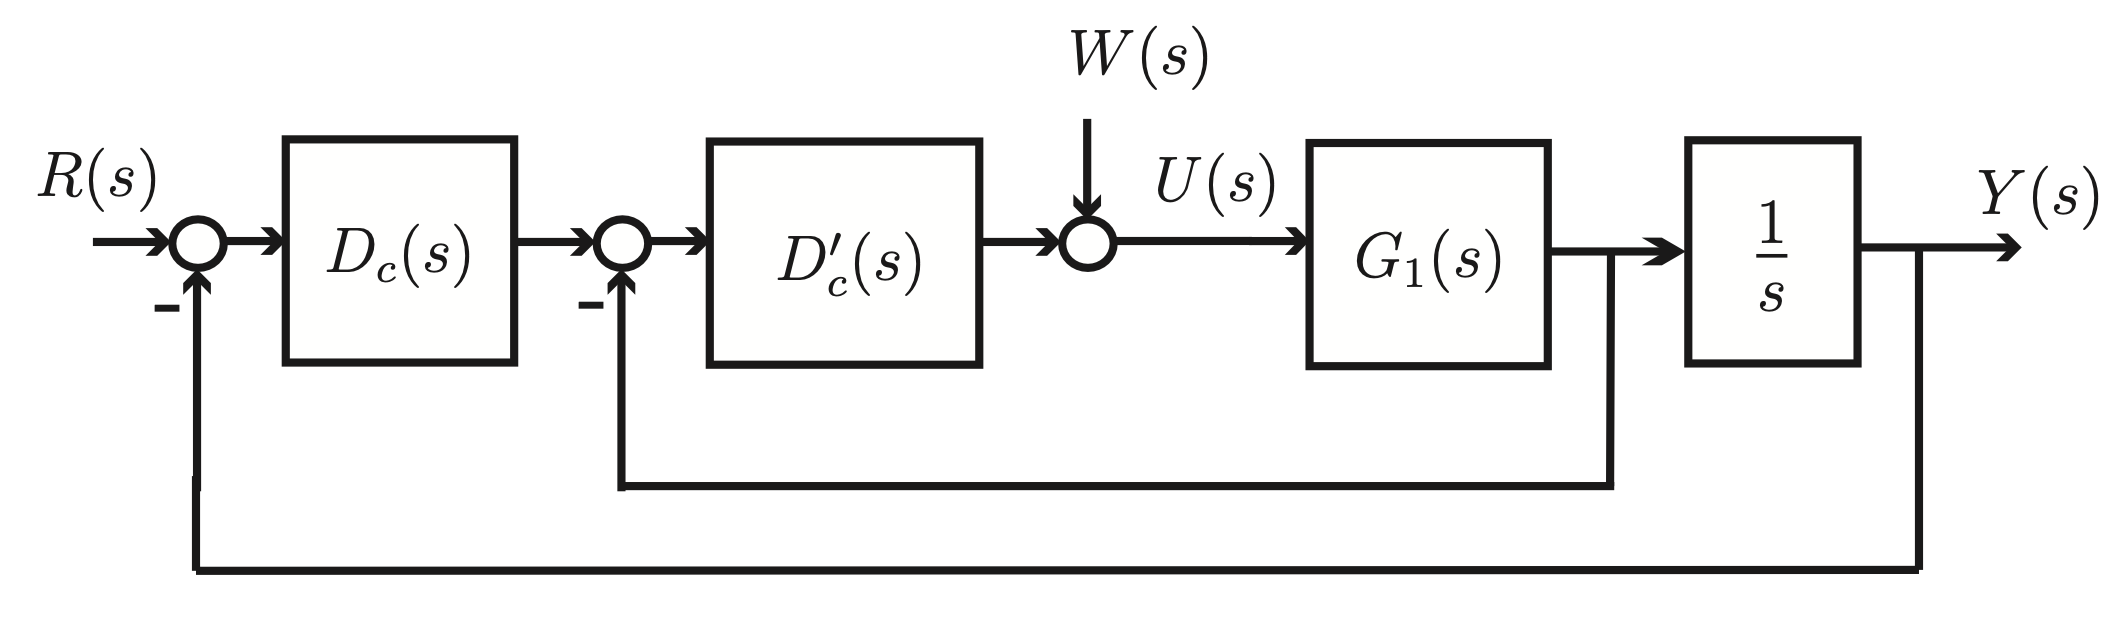


__Note:__ This section needs the plant TF.

#### Second-order approximation of $G_1$

$$
G_1 \approx \hat{G}_1 = \frac{\gamma \omega_n^2}{s^2 + 2 \zeta \omega_n s + \omega_n^2}
$$

<div class="alert alert-block alert-info">

__Note:__ $\hat{G}_1$ is to be used for controller design, but $G_1$ should be used for closed-loop analysis.

</div>

Pour obtenir les parametre du système de second ordre, on regarde l'impulse response de G (car c'est G1=G*s)

Nous mesurons :
$$K=1.637$$
$$t_p=0.15735$$
$$y(tp)=2.3245$$
$$\alpha = 1$$
de la on peut calculer :
$$\gamma = \frac{K}{\alpha}= \frac{1.637}{1}=1.637$$
$$M_p=\frac{y(t_p)-K}{K}=\frac{2.3245-1.637}{1.637}=0.41997$$
$$\zeta = \sqrt{\frac{(ln(M_p))^2}{\pi^2+(ln(M_p))^2}}=\sqrt{\frac{(ln(0.41997))^2}{\pi^2+(ln(0.41997))^2}}=0.266193$$
$$\omega_n=\frac{\pi}{t_p*\sqrt{1-\zeta ^2}}=\frac{\pi}{0.15735*\sqrt{1-0.266193 ^2}}=20.7130$$

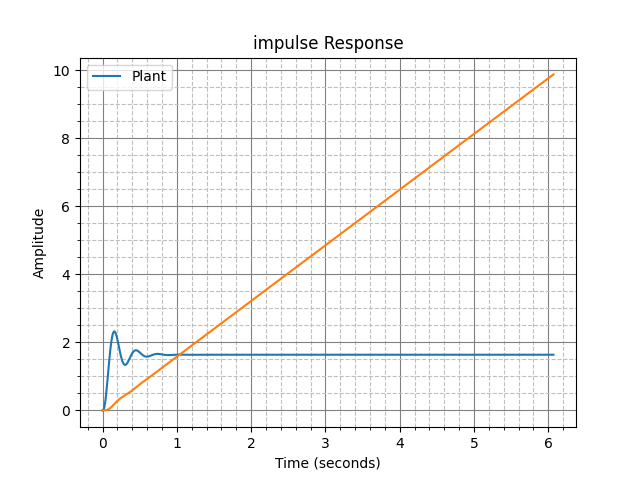

In [12]:
# impulse Response of the plant
yout, tout = impulse(G) #derivative of G to get the slope
plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)    
yout, tout = step(G)
plt.plot(tout, yout)
# Plot data
plt.title('impulse Response')                              # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Plant'])                                   # Display legend
plt.show()

In [13]:
# Define an auxilary system G1
s = tf('s')
# G1 = G * s  # This will lead in some undesired results!!!
            # TODO: Correct this before proceeding

# TODO: Approximation of G1 as second order system
# From the step response of G1, identify the parameters 𝛄, 𝛇 and 𝛚_n of an approximate second-order 
# model for the system. (Chapter 3, slide 41)
# 
# Specify these variables:
#   * gamma    -> Gain of an approximate second-order system (𝛄)
#   * zeta     -> Damping ratio of an approximate second-order system (𝛇)
#   * omega_n  -> Natural freq. of an approximate second-order system (𝛚_n)
gamma = 1.637
zeta = 0.266193
omega_n =20.7130 

G1 = (gamma*omega_n*omega_n)/(s*s+2*zeta*omega_n*s+omega_n*omega_n)

#### Inner Loop
Design a PID controller, $D_c' (s)$, for the inner loop using the model reference method to achieve a bandwidth of $50$ rad/s.

In [14]:
# TODO: Design PID controller for inner loop of cascade controller
# Specify these variables:
#   * Dc_prime -> PID controller for inner loop
tau_m = 1/50 #1/50 = 1/bandwidth
Kp = 2*zeta/(gamma*omega_n*tau_m)
Ki = 1/(gamma*tau_m)
Kd = 1/(gamma*omega_n*omega_n*tau_m)
Ti = Kp/Ki
Td = Kd/Kp
tau = (Kd/Kp) * 0.1

Dc_prime = minreal(Kp*(1+1/(Ti*s)+(Td*s)/(tau*s+1)))  #structure MIXED du PID

print_system("Plant (K)", Dc_prime)

0 states have been removed from the model


<IPython.core.display.Math object>

#### Outer Loop
Design a proportional controller for the outer loop, $D_c(s) = k_P$, to achieve a desired bandwidth of $7$ rad/s. 

__Note__: Inner loop is much faster than the outer loop so its dynamic can be ignored in the design of the controller for the outer loop.

In [15]:
# TODO: Design proportional controller for outer loop of cascade controller
# Specify these variables:
#   * Dc  -> Proportional controller for outer loop
#Dc = G1/7 # Dc = G1/bandwidth
tau_m = 1/7 #1/7 = 1/bandwidth
Dc=1/tau_m 
print(Dc)

7.0


#### Closed-loop Analysis

In [25]:
# TODO: Compute the transfer function between the reference signal R, and the error E
#       Compute the transfer function between the reference signal R, and the input U
#       Compute the transfer function between the reference signal R, and the output Y
#       Compute the transfer function between the disturbance W, and the output Y

# Specify this variables:
#   * S -> TF between the reference signal and the error
#   * U -> TF between the reference signal and the input
#   * T -> TF between the reference signal and the output
#   * V -> TF between the disturbance and the output

Denom_feedback = minreal(1+(1+s/Dc)*(Dc*Dc_prime*G))

C_S = minreal(1/Denom_feedback)
C_U = minreal(Dc*Dc_prime/Denom_feedback)
C_T = minreal(Dc*Dc_prime*G*(1/s)/Denom_feedback)
C_V = minreal((G*1/s)/Denom_feedback)

print_system("Plant(C_S)",C_S)
print_system("Plant(C_U)",C_U)
print_system("Plant(C_T)",C_T)
print_system("Plant(C_V)",C_V)

0 states have been removed from the model
0 states have been removed from the model
2 states have been removed from the model
6 states have been removed from the model
5 states have been removed from the model


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Comparison with ZN-PID and cascade controllers
<span style="color:red">__Q__:</span> Comparison of the performance of the cascade controller with the ZN-PID controller in terms of Tracking performance, Control effort, and Disturbance rejection.  
<span style="color:blue">__A__:</span>

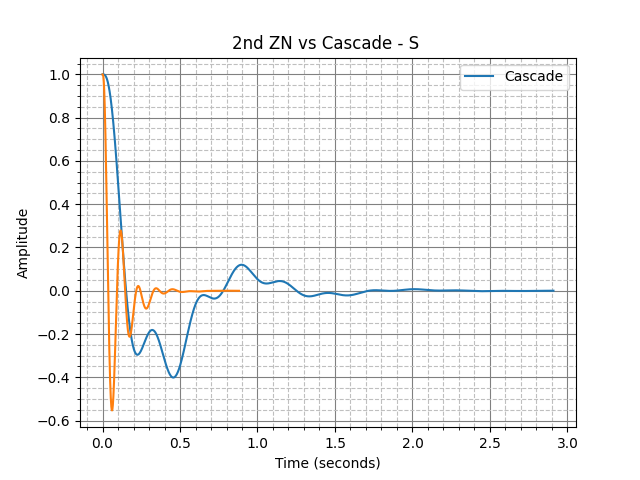

In [31]:
# TODO: Compare with ZN-PID controller (Plot the responses on the same plot and comment on them!)
# impulse Response of the plant
 #derivative of G to get the slope
yout, tout = step(S)
plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)    
yout, tout = step(C_S)
plt.plot(tout, yout)
# Plot data
plt.title('2nd ZN vs Cascade - S ')                              # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Cascade'])                                   # Display legend
plt.show()


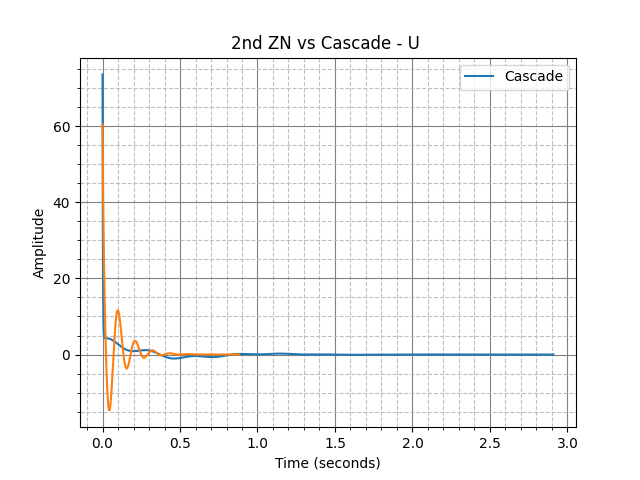

In [33]:
yout, tout = step(U)
plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)    
yout, tout = step(C_U)
plt.plot(tout, yout)
# Plot data
plt.title('2nd ZN vs Cascade - U ')                              # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Cascade'])                                   # Display legend
plt.show()


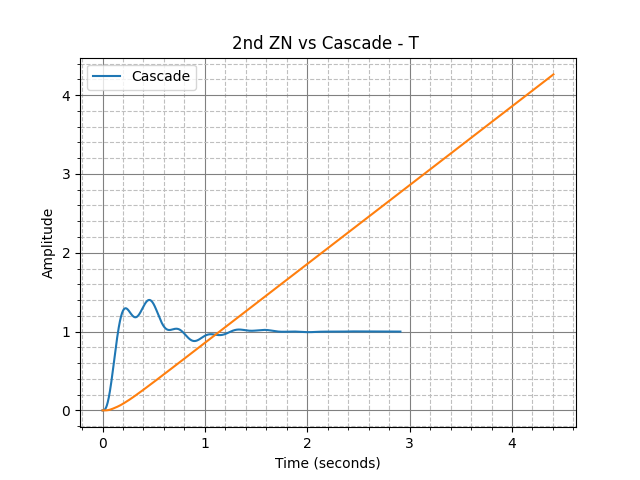

In [35]:
yout, tout = step(T)
plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)    
yout, tout = step(C_T)
plt.plot(tout, yout)
# Plot data
plt.title('2nd ZN vs Cascade - T ')                              # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Cascade'])                                   # Display legend
plt.show()

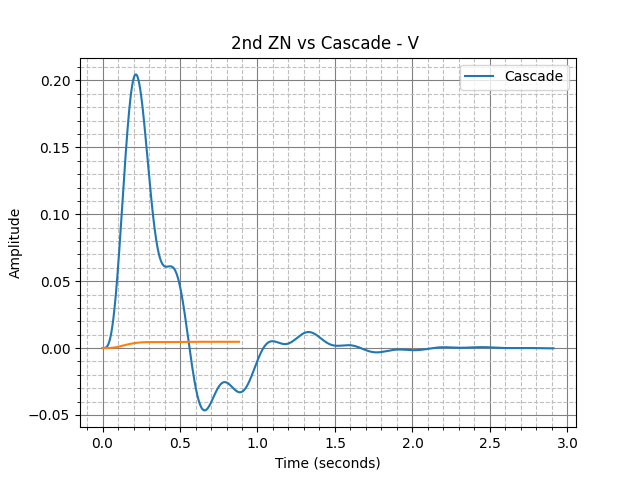

In [37]:
yout, tout = step(V)
plt.figure()                                            # Create a new empty figure
plt.plot(tout, yout)    
yout, tout = step(C_V)
plt.plot(tout, yout)
# Plot data
plt.title('2nd ZN vs Cascade - V ')                              # Title of the plot
plt.xlabel('Time (seconds)')                            # Label for the x-axis
plt.ylabel('Amplitude')                                 # Label for the y-axis
plt.minorticks_on()                                     # Display minor tickmarks
plt.grid(which='major', color="0.5", linestyle='-')     # Display major grid lines 
plt.grid(which='minor', color="0.75", linestyle='--')   # Display minor grid lines
plt.legend(['Cascade'])                                   # Display legend
plt.show()